In [295]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input,Activation,Dense,Flatten,Reshape,Conv2D,Conv2DTranspose,Dropout,BatchNormalization,UpSampling2D,LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os

os.environ['PYTHONHASHSEED']=str(1)
tf.random.set_seed(1)
np.random.seed(1)
random.seed(1)

import sys
print("python version", sys.version)
print("TF version", tf.__version__)
if tf.test.is_gpu_available():
  print("GPU available")
else:
  print("GPU unavailable")


(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()
x_train=x_train[np.isin(y_train,[9])] # 9번 부류는 ankle boot


python version 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
TF version 2.8.0
GPU available


In [296]:
# modification: recuding dataset to save time
print("original dataset size: ", len(x_train), len(x_test))
x_train = x_train[:100]
x_test = x_test[:100]

x_train = (x_train.astype('float32')/255.0)*2.0-1.0 # [-1,1] 구간
x_test = (x_test.astype('float32')/255.0)*2.0-1.0
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

print("reduced dataset size: ", len(x_train), len(x_test))

original dataset size:  6000 10000
reduced dataset size:  100 100


In [297]:
batch_siz=64
epochs=500
dropout_rate=0.4
batch_norm=0.9
zdim=100 # 잠복 공간의 차원

# 분별망 D 설계
discriminator_input=Input(shape=(28, 28, 1)) 
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(2,2))(discriminator_input)
x=Dropout(dropout_rate)(x)
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Dropout(dropout_rate)(x)
x=Conv2D(128,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Dropout(dropout_rate)(x)
x=Flatten()(x)
discriminator_output=Dense(1,activation='sigmoid')(x)
discriminator=Model(discriminator_input,discriminator_output)
#discriminator.summary()

# 생성망 G 설계
generator_in_channels = 32

generator_input=Input(shape=(zdim,)) 
x=Dense(7*7*generator_in_channels)(generator_input)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Reshape((7,7,generator_in_channels))(x)
x=UpSampling2D()(x)
x=Conv2D(64,(3,3),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=UpSampling2D()(x)
x=Conv2D(64,(3,3),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Conv2D(64,(3,3),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Conv2D(1,(5,5),activation='tanh',padding='same')(x)
generator_output=x
generator=Model(generator_input,generator_output)
#generator.summary()

discriminator.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

discriminator.trainable=False
gan_input=Input(shape=(zdim,))
gan_output=discriminator(generator(gan_input))
gan=Model(gan_input,gan_output)
gan.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

#gan.summary()
trainable_count = np.sum([K.count_params(w) for w in gan.trainable_weights])
print('[Baseline] Trainable params: {:,}'.format(trainable_count))

[Baseline] Trainable params: 255,841


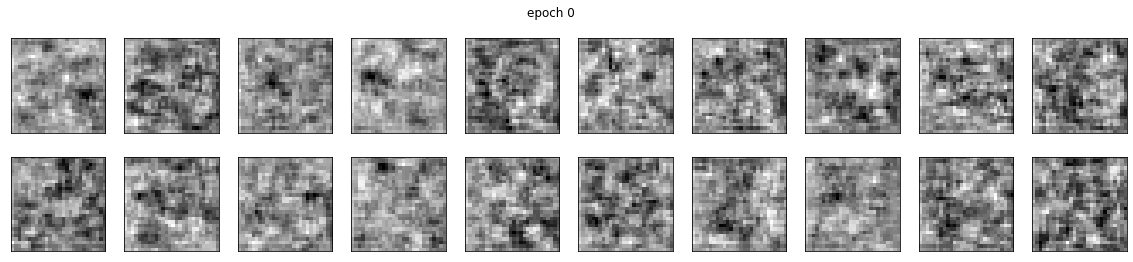

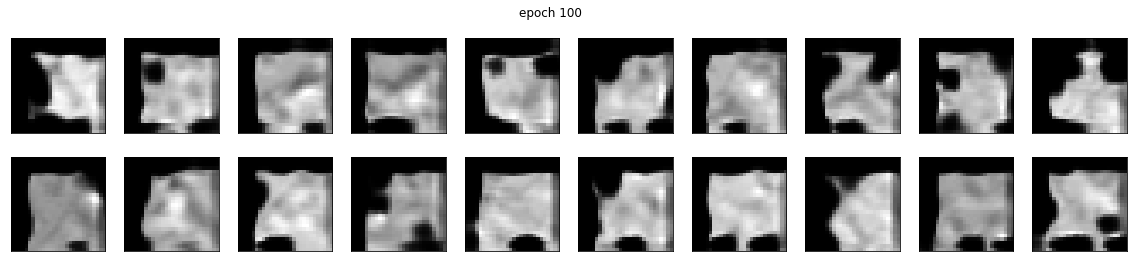

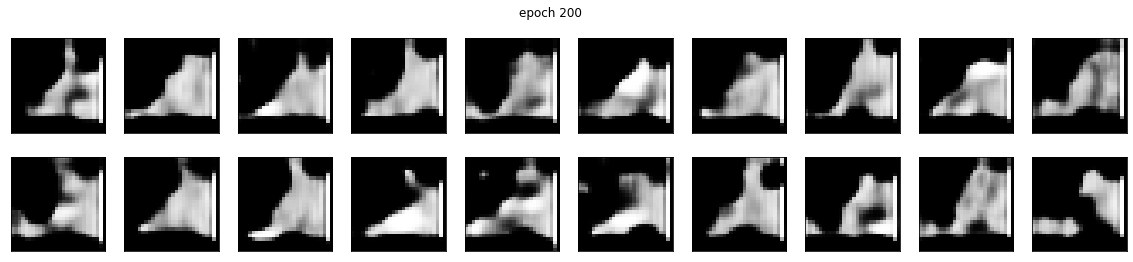

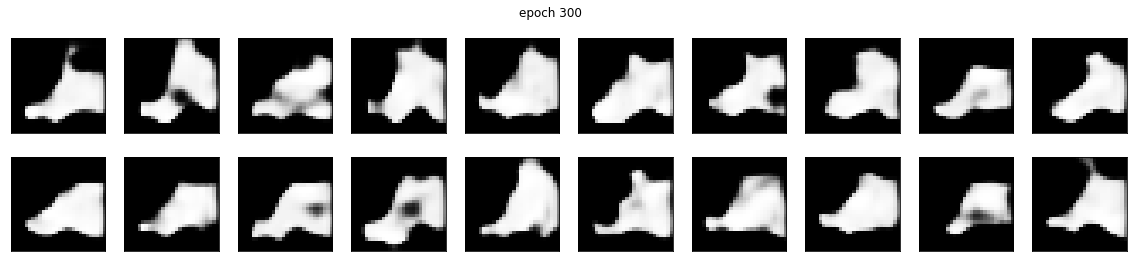

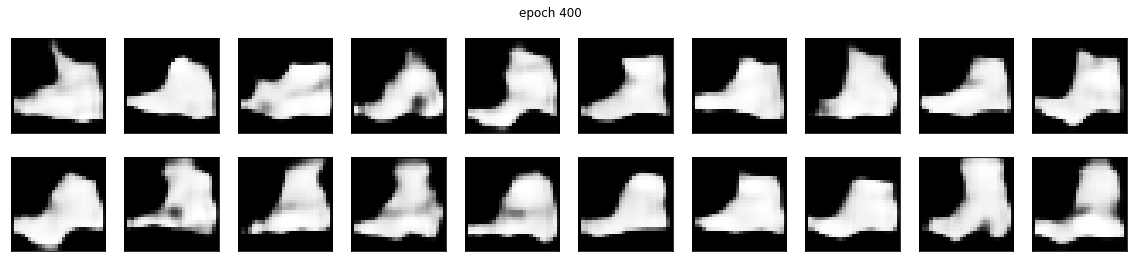

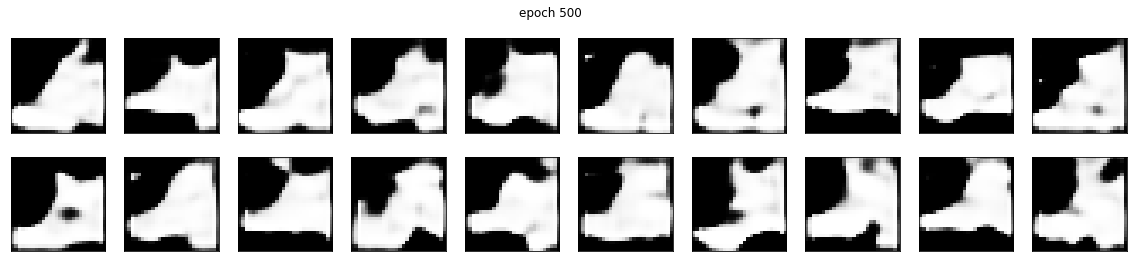

In [298]:

def train_discriminator(x_train):
    c=np.random.randint(0,x_train.shape[0],batch_siz)
    real=x_train[c]
    c1 = discriminator.train_on_batch(real,np.ones((batch_siz,1)))

    p=np.random.normal(0,1,(batch_siz,zdim))
    fake=generator.predict(p)
    c2 = discriminator.train_on_batch(fake,np.zeros((batch_siz,1)))

def train_generator():
    p=np.random.normal(0,1,(batch_siz,zdim))
    gan.train_on_batch(p,np.ones((batch_siz,1)))

import time
start_time = time.time()

for i in range(epochs+1): # 학습을 수행
    train_discriminator(x_train)
    train_generator()
    if(i%100==0): # 학습 도중 100세대마다 중간 상황 출력
        plt.figure(figsize=(20, 4))
        plt.suptitle('epoch '+str(i))
        for k in range(20):
            plt.subplot(2,10,k+1)
            img=generator.predict(np.random.normal(0,1,(1,zdim)))
            plt.imshow(img[0].reshape(28,28),cmap='gray')
            plt.xticks([]); plt.yticks([])
        plt.show()

g_train_time = time.time() - start_time  


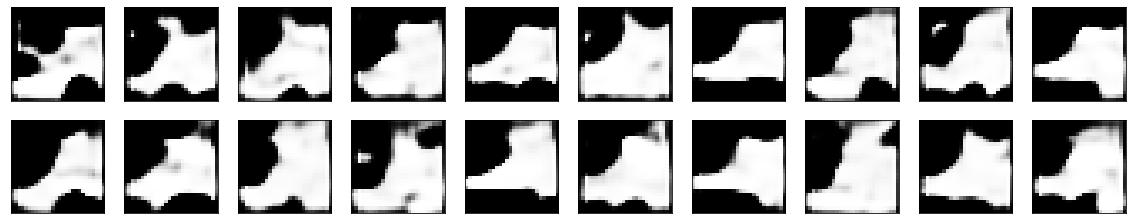

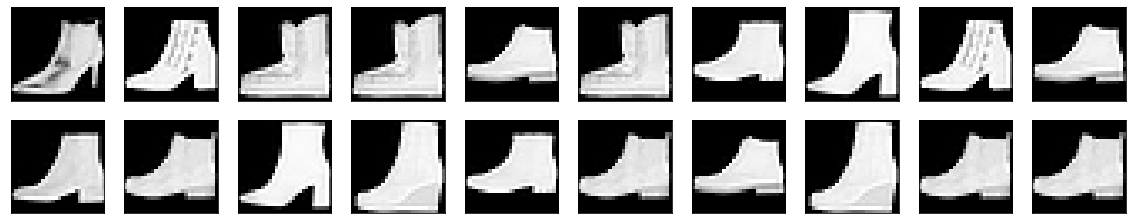

Param: 255841, Difference: 0.2650, Time: 50.50


In [299]:

imgs=generator.predict(np.random.normal(0,1,(20,zdim)))
plt.figure(figsize=(20,10)) # 학습을 마친 후 20개 샘플을 생성하여 출력
for i in range(20):
    plt.subplot(5,10,i+1)
    plt.imshow(imgs[i].reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])
    
# 훈련 집합 x_train에서 img와 가장 가까운 영상을 찾아주는 함수
def most_similar(img,x_train):
    vmin=1.0e10
    for i in range(len(x_train)):
        dist=np.mean(np.abs(img-x_train[i]))
        if dist<vmin:
            imin,vmin=i,dist
    return x_train[imin], vmin

# 20개의 영상에 대해 가장 가까운 영상을 찾아 보여줌
vminlist = []
plt.figure(figsize=(20,10))
for k in range(20):
    plt.subplot(5,10,k+1)
    img, vmin = most_similar(imgs[k],x_train)
    vminlist.append(vmin)
    plt.imshow(img.reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])
plt.show()

print('Param: {}, Difference: {:6.4f}, Time: {:5.2f}'.format(trainable_count, sum(vminlist)/20, g_train_time))

In [350]:
batch_siz=100
epochs=500
dropout_rate=0.6
batch_norm=0.97
zdim=28 # 잠복 공간의 차원

# -----------------------------------------------------
# Build your own GAN
# -----------------------------------------------------

# 분별망 D 설계
discriminator_input=Input(shape=(28, 28, 1))
x=Conv2D(8,(3,3),activation='relu',padding='same',strides=(2,2))(discriminator_input)
x=Dropout(dropout_rate)(x)
x=Conv2D(16,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Dropout(dropout_rate)(x)
x=Flatten()(x)
discriminator_output=Dense(1,activation='sigmoid')(x)
discriminator=Model(discriminator_input,discriminator_output)
discriminator.summary()

Model: "model_212"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_216 (InputLayer)      [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_313 (Conv2D)         (None, 14, 14, 8)         80        
                                                                 
 dropout_149 (Dropout)       (None, 14, 14, 8)         0         
                                                                 
 conv2d_314 (Conv2D)         (None, 7, 7, 16)          1168      
                                                                 
 dropout_150 (Dropout)       (None, 7, 7, 16)          0         
                                                                 
 flatten_73 (Flatten)        (None, 784)               0         
                                                                 
 dense_150 (Dense)           (None, 1)                 78

In [351]:
# 생성망 G 설계
generator_in_channels = 4

generator_input=Input(shape=(zdim,))
x=Dense(7*7*generator_in_channels)(generator_input)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Reshape((7,7,generator_in_channels))(x)
x = UpSampling2D()(x)
x = Conv2D(16,(3, 3),padding="same")(x)

x = tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='same', strides = 1)(x)
x=BatchNormalization(momentum=batch_norm)(x)
x = Activation('LeakyReLU')(x)

x = Conv2DTranspose(32,(5, 5),padding="same", strides=2)(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='same', strides = 1)(x)
x=BatchNormalization(momentum=batch_norm)(x)
x = Activation('LeakyReLU')(x)

x=Conv2D(1,(5,5),activation='tanh',padding='same')(x)
generator_output=x
generator=Model(generator_input,generator_output)
generator.summary()

Model: "model_213"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_217 (InputLayer)      [(None, 28)]              0         
                                                                 
 dense_151 (Dense)           (None, 196)               5684      
                                                                 
 batch_normalization_248 (Ba  (None, 196)              784       
 tchNormalization)                                               
                                                                 
 activation_248 (Activation)  (None, 196)              0         
                                                                 
 reshape_77 (Reshape)        (None, 7, 7, 4)           0         
                                                                 
 up_sampling2d_68 (UpSamplin  (None, 14, 14, 4)        0         
 g2D)                                                    

In [352]:
discriminator.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

discriminator.trainable=False
gan_input=Input(shape=(zdim,))
gan_output=discriminator(generator(gan_input))
your_gan=Model(gan_input,gan_output)
your_gan.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

your_gan.summary()
your_trainable_count = np.sum([K.count_params(w) for w in your_gan.trainable_weights])
print('[YourGAN] Trainable params: {:,}'.format(your_trainable_count))

def train_discriminator(x_train):
    c=np.random.randint(0,x_train.shape[0],batch_siz)
    real=x_train[c]
    c1 = discriminator.train_on_batch(real,np.ones((batch_siz,1)))

    p=np.random.normal(0,1,(batch_siz,zdim))
    fake=generator.predict(p)
    c2 = discriminator.train_on_batch(fake,np.zeros((batch_siz,1)))

    return c1, c2

def train_generator():
    p=np.random.normal(0,1,(batch_siz,zdim))
    c3 = your_gan.train_on_batch(p,np.ones((batch_siz,1)))

    return c3

Model: "model_214"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_218 (InputLayer)      [(None, 28)]              0         
                                                                 
 model_213 (Functional)      (None, 28, 28, 1)         20885     
                                                                 
 model_212 (Functional)      (None, 1)                 2033      
                                                                 
Total params: 22,918
Trainable params: 20,397
Non-trainable params: 2,521
_________________________________________________________________
[YourGAN] Trainable params: 20,397


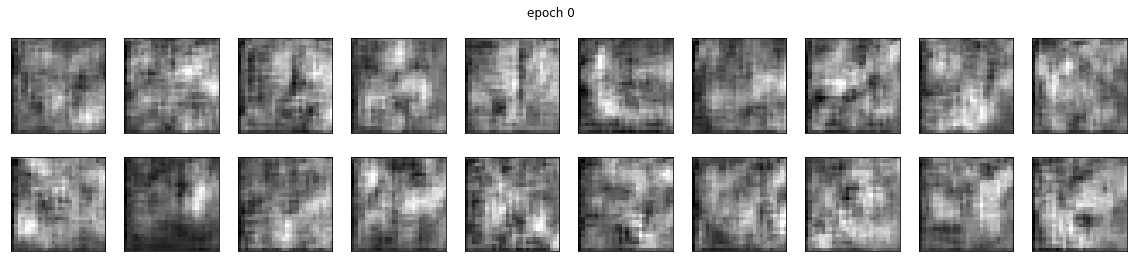

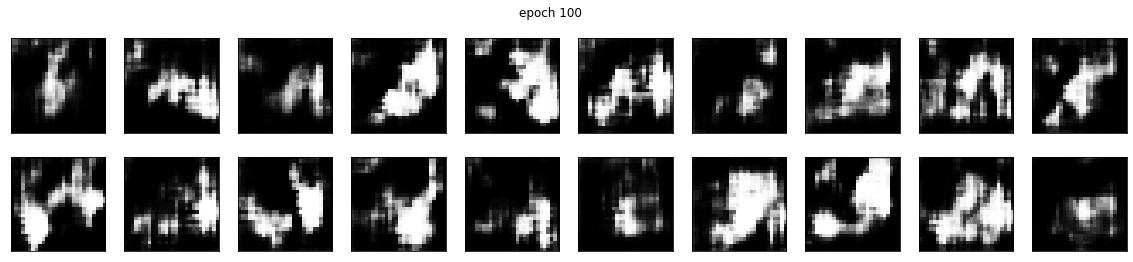

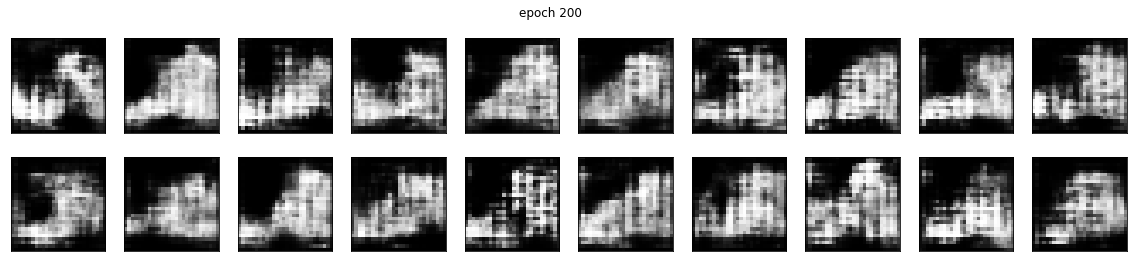

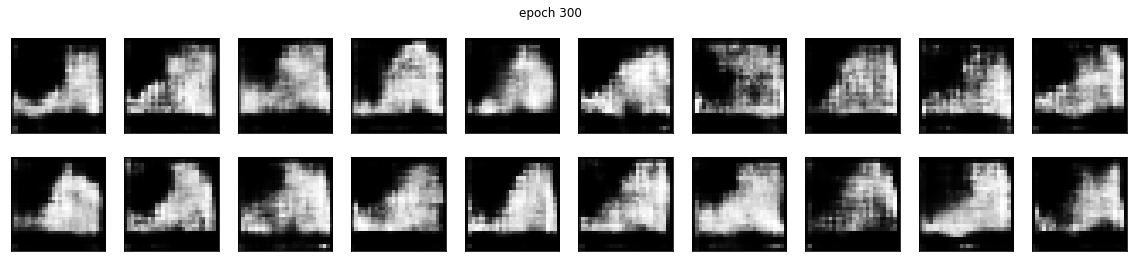

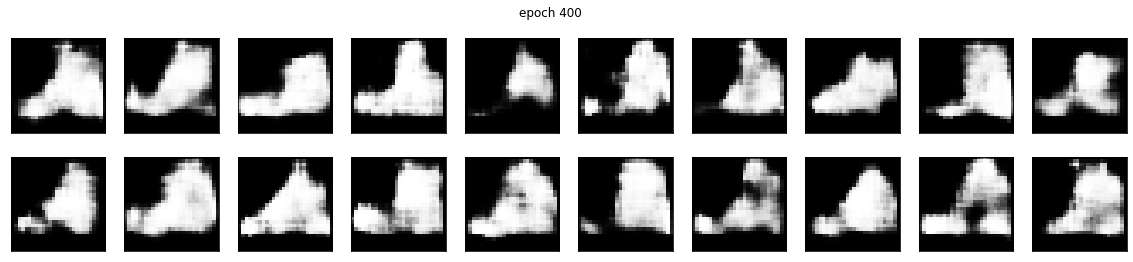

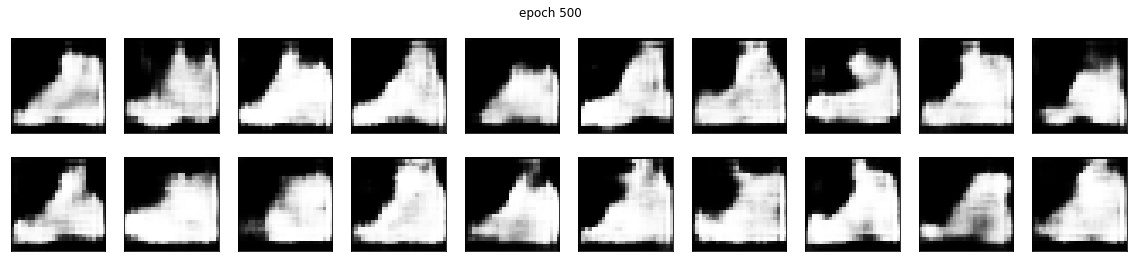

In [353]:
import time
start_time = time.time()
temp = list()
for i in range(epochs+1): # 학습을 수행
    c1, c2 = train_discriminator(x_train)
    c3 = train_generator()
    temp.append((c1[1], c2[1], c3[1]))
    if(i%100==0): # 학습 도중 20세대마다 중간 상황 출력
        plt.figure(figsize=(20, 4))
        plt.suptitle('epoch '+str(i))
        for k in range(20):
            plt.subplot(2,10,k+1)
            img=generator.predict(np.random.normal(0,1,(1,zdim)))
            plt.imshow(img[0].reshape(28,28),cmap='gray')
            plt.xticks([]); plt.yticks([])
        plt.show()
    # if c2[1] < 0.1 and c3[1] > 0.9:
    #   break
g_train_time = time.time() - start_time  

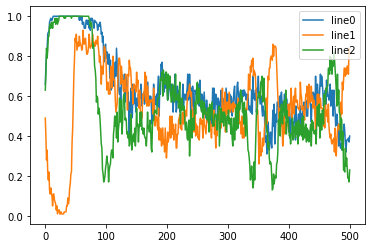

<Figure size 1440x1440 with 0 Axes>

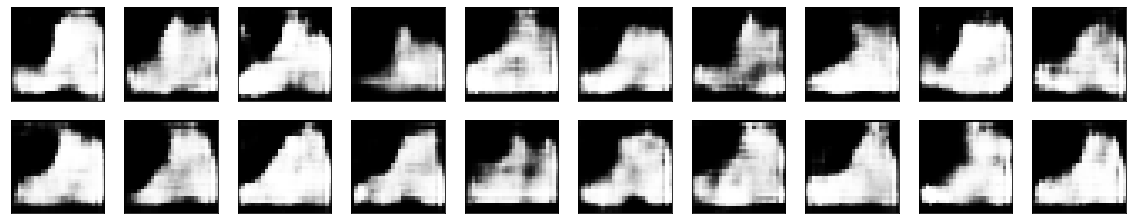

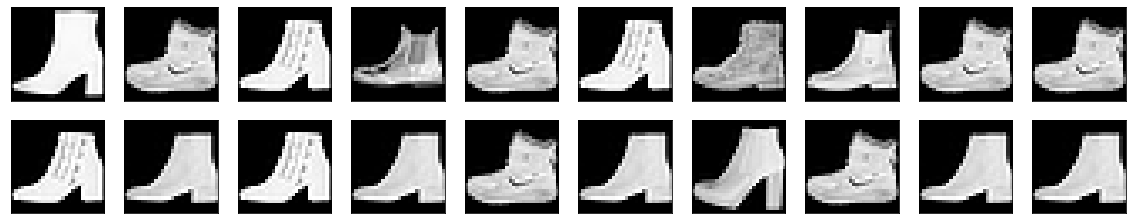

(base vs. your) Param : 92.0%, Difference: 0.1073, Time: 46.45
Model: "model_214"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_218 (InputLayer)      [(None, 28)]              0         
                                                                 
 model_213 (Functional)      (None, 28, 28, 1)         20885     
                                                                 
 model_212 (Functional)      (None, 1)                 2033      
                                                                 
Total params: 22,918
Trainable params: 20,397
Non-trainable params: 2,521
_________________________________________________________________


In [354]:
c1, c2, c3 = zip(*temp)

plt.plot(c1, label = 'line0')
# 정답에 대한 정확률
plt.plot(c2, label = 'line1')
# 가짜에 대한 정확률

# c1, c2가 높으면 정답을 잘 찾고, 가짜를 잘 분별한다는 뜻임

plt.plot(c3, label = 'line2')
# 속인 정확률, 높을 수록 잘 속였다는 증거
plt.legend(loc = 'upper right')
plt.figure(figsize = (20, 20))
plt.show()


imgs=generator.predict(np.random.normal(0,1,(20,zdim)))
plt.figure(figsize=(20,10)) # 학습을 마친 후 20개 샘플을 생성하여 출력
for i in range(20):
    plt.subplot(5,10,i+1)
    plt.imshow(imgs[i].reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])
    
# 훈련 집합 x_train에서 img와 가장 가까운 영상을 찾아주는 함수
def most_similar(img,x_train):
    vmin=1.0e10
    for i in range(len(x_train)):
        dist=np.mean(np.abs(img-x_train[i]))
        if dist<vmin:
            imin,vmin=i,dist
    return x_train[imin], vmin

# 20개의 영상에 대해 가장 가까운 영상을 찾아 보여줌
your_vminlist = []
plt.figure(figsize=(20,10))
for k in range(20):
    plt.subplot(5,10,k+1)
    img, vmin = most_similar(imgs[k],x_train)
    your_vminlist.append(vmin)
    plt.imshow(img.reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])
plt.show()

print('(base vs. your) Param : {:.1%}, Difference: {:6.4f}, Time: {:5.2f}'
.format((trainable_count - your_trainable_count) / trainable_count, (sum(vminlist) - sum(your_vminlist)), g_train_time))

your_gan.summary()